# Residential Energy Consumption Data Pipeline: From Web Scraping to Final Storage

This script automates the full pipeline for processing residential energy consumption data. It begins by scraping raw data from a public data source using Python's requests and BeautifulSoup. The scraped data is then processed, cleaned, and aggregated using SQL queries within PySpark. Finally, the processed data is stored in Parquet format, ensuring efficient future access for further analysis.

The dataset we're working with represents detailed Residential Load Data for various U.S. locations, provided by the National Renewable Energy Laboratory (NREL). This dataset includes hourly load profiles, meaning it captures energy consumption for heating, cooling, electricity, and gas at regular intervals throughout the day for residential buildings.

The data is divided into three categories or folders:

- Base: General dataset providing foundational consumption data.
- High: Represents data for homes with characteristics like poor insulation, larger sizes, and less efficient HVAC systems, resulting in higher energy consumption.
- Low: Contains data for homes with better insulation, smaller sizes, and more efficient HVAC systems, representing lower energy consumption.

Each location's data is stored in individual CSV files, organized by state and city. The files provide hourly data in kilowatt-hours (kWh) and cover a full year. This dataset allows for in-depth analysis of energy demands across different climates and building types, making it useful for energy efficiency projects, urban planning, and policy development.

In this project, we focus on the High and Low dataset to analyze and transform the data, applying operations like aggregation by state and date to generate insights into energy consumption trends and to compare the consumption between High and Low profiles. The dataset is processed in PySpark and saved in Parquet format to facilitate scalable and efficient querying.

## Medallion architecture

We are utilizing the Medallion Architecture to structure the data processing pipeline. This approach divides the process into three layers, each serving a distinct role in transforming raw data into refined insights.

### Bronze Layer (Raw Data)

In this part of the project, the Bronze Layer stores the raw data extracted directly from web scraping. This includes original CSV files of energy consumption data by state and simulation type (e.g., HIGH, LOW). The data remains untouched, retaining its original structure, inconsistencies, and errors.

- Purpose: Retain the original dataset in its raw form for potential future reference.
- Format: Stored as CSV files, categorized by state and simulation type.

## Silver Layer (Cleaned and Transformed Data)

The Silver Layer in this project involves cleaning and transforming the raw data for better usability. This includes tasks such as extracting metadata (e.g., state, city) from filenames, cleaning the Date/Time column for accurate time-based analysis, renaming columns for clarity, converting energy measurements from kW to MW and ensuring consistent data types for analysis.

- Purpose: Clean and standardize the raw data to facilitate further processing and analysis.

- Format: Stored as Parquet files to optimize read/write operations.

## Gold Layer (Aggregated and Summarized Data)

In the Gold Layer, we further refine the cleaned data, summarizing and aggregating it to generate insights. The energy consumption data is grouped by state and date, and ready for visualization and analysis.

- Purpose: Provide a refined, final dataset for in-depth analysis, decision-making, and visualization.
- Format: Stored as Parquet or CSV files, optimized for querying.


## Importing the necessary libraries

In [1]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import pandas as pd
from pyspark.sql.functions import split, col, concat, lit, regexp_extract, sum, avg, count, input_file_name
from pyspark.sql.types import DoubleType
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin
import zipfile
import os
import mimetypes
import shutil
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sqlalchemy import create_engine

## Data extraction

In this part of the project, the code is responsible for automating the extraction of data from the U.S. Department of Energy website. It uses web scraping to locate and download a compressed dataset ("Residential Load Data Compressed.zip") that contains energy consumption profiles. The BeautifulSoup library is utilized to parse the HTML content of the webpage, find the desired file, and then a GET request is used to download the file in manageable chunks while showing progress feedback.

In [2]:
# The URL of the dataset index page, pointing to the page where the dataset can be found.
base_url = "https://catalog.data.gov/dataset/commercial-and-residential-hourly-load-profiles-for-all-tmy3-locations-in-the-united-state-bbc75"

# Send a GET request to fetch the page content. A custom 'User-Agent' header is included to mimic a real browser request.
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
}
response = requests.get(base_url, headers=headers)

# Check if the request was successful by confirming that the status code is 200 (OK).
if response.status_code == 200:
    # Parse the HTML content using BeautifulSoup, making it easier to navigate and extract the required information.
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Search for the link element with the title "Residential Load Data Compressed.zip", where the target dataset is located.
    target_link = soup.find('a', class_='heading', title="Residential Load Data Compressed.zip")
    
    # If the link is found, proceed to locate the parent element containing the download button.
    if target_link:
        # Find the 'btn-group' div that holds the download button.
        btn_group_div = target_link.find_next('div', class_='btn-group')
        if btn_group_div:
            # Extract the download button element from the div.
            download_button = btn_group_div.find('a', class_='btn btn-primary')
            if download_button:
                # Retrieve the download URL from the button's 'href' attribute.
                download_url = download_button.get('href')
                full_download_url = urljoin(base_url, download_url)  # Join the base URL with the relative link to get the complete URL.
                print(f"Found the direct download link: {full_download_url}")
                
                # Start the file download by sending another GET request to the dataset's download link.
                with requests.get(full_download_url, headers=headers, stream=True) as zip_response:
                    zip_response.raise_for_status()  # Ensure no errors occurred during the download.
                    total_size = int(zip_response.headers.get('content-length', 0))  # Retrieve the total size of the file in bytes.
                    chunk_size = 1024  # 1 KB chunk size for streaming the download.
                    num_chunks = total_size // chunk_size  # Calculate the total number of chunks.

                    # Open a new file in binary mode to write the downloaded content.
                    with open('Residential_Load_Data.zip', 'wb') as file:
                        print(f"Downloading file, size: {total_size / (1024 * 1024):.2f} MB")  # Convert bytes to MB for logging.
                        
                        # Write each chunk of data to the file.
                        for chunk_num, chunk in enumerate(zip_response.iter_content(chunk_size=chunk_size)):
                            file.write(chunk)
                            # Print progress log every 10% of the total size.
                            if chunk_num % (num_chunks // 10 or 1) == 0:
                                print(f"Downloaded {chunk_num * chunk_size / (1024 * 1024):.2f} MB of {total_size / (1024 * 1024):.2f} MB")

                        print("Download complete and zip file saved!")
            else:
                # Error message if the download button could not be found in the 'btn-group' div.
                print("Could not find the download button in the 'btn-group' div.")
        else:
            # Error message if the 'btn-group' div could not be found.
            print("Could not find the 'btn-group' div.")
    else:
        # Error message if the dataset link could not be found.
        print("Could not find the 'Residential Load Data Compressed.zip' link.")
else:
    # Error message if the page could not be accessed successfully.
    print(f"Error: Unable to access the page. Status code: {response.status_code}")


Found the direct download link: https://data.openei.org/files/153/RESIDENTIAL_LOAD_DATA_E_PLUS_OUTPUT.zip
Downloaded 0.00 MB of 894.44 MB
Downloaded 89.44 MB of 894.44 MB
Downloaded 178.89 MB of 894.44 MB
Downloaded 268.33 MB of 894.44 MB
Downloaded 357.78 MB of 894.44 MB
Downloaded 447.22 MB of 894.44 MB
Downloaded 536.67 MB of 894.44 MB
Downloaded 626.11 MB of 894.44 MB
Downloaded 715.55 MB of 894.44 MB
Downloaded 805.00 MB of 894.44 MB
Downloaded 894.44 MB of 894.44 MB
Download complete and zip file saved!


This part of the code handles the extraction of the compressed dataset after the file has been downloaded. The script checks if the extraction folder exists, creates it if necessary, and then unzips the contents of the dataset into that folder using the zipfile library. This ensures that the raw data is ready for further processing in the next steps of the project.

In [3]:
# Path to the zip file
zip_file_path = './Residential_Load_Data.zip'
extract_path = './Residential_Load_Data'

# Create the directory if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction complete! Files extracted to:", extract_path)

Extraction complete! Files extracted to: ./Residential_Load_Data


In [4]:
spark = SparkSession.builder \
    .appName("Load Residential Load Data") \
    .getOrCreate()

## Data transformation

This section of the code performs the data transformation steps. It reads all the CSV files that were extracted from the zip file and combines them into a single PySpark DataFrame. The filename of each CSV file is used to extract the state and city information, which are then added as new columns to the DataFrame. Additionally, the 'Date/Time' column is split into separate 'Date' and 'Time' columns to make the data easier to work with.

In [5]:
# Define the base path to the CSV files extracted from the Residential Load Data zip file
base_path = "./Residential_Load_Data/RESIDENTIAL_LOAD_DATA_E_PLUS_OUTPUT/HIGH/*.csv"

# Read all the CSV files from the specified directory into a PySpark DataFrame
df = spark.read.option("header", "true").csv(base_path)

# Add a new column 'filename' that captures the name of the file from which the data originates
df = df.withColumn("filename", F.input_file_name())

# Extract the 'estado' (state) from the 'filename' column using regex (state code between 'USA_' and '_')
df = df.withColumn("estado", F.regexp_extract(F.col("filename"), r"USA_(\w+)_", 1))

# Extract the 'cidade' (city) from the 'filename' column using regex (city name between 'USA_' and '.AP')
df = df.withColumn("cidade", F.regexp_extract(F.col("filename"), r"USA_\w+_(.+?)\.AP", 1))

# Drop the 'filename' column since it's no longer needed after extracting 'estado' and 'cidade'
df = df.drop("filename")

# Split the 'Date/Time' column into two separate 'Date' and 'Time' columns by splitting on two spaces
df = df.withColumn("Date", split(F.col("Date/Time"), "  ").getItem(0)) \
       .withColumn("Time", split(F.col("Date/Time"), "  ").getItem(1))

# Drop the original 'Date/Time' column as it's been split into separate 'Date' and 'Time' columns
df = df.drop("Date/Time")

This section of the code is focused on renaming the columns of the DataFrame to simplify their names and transforming all numeric values to float type.

- A dictionary (columns_rename_map) is used to map the original complex column names (e.g., "Electricity kW") to more straightforward ones (e.g., "Electricity_Facility_kW").

- The for loop iterates over each key-value pair in the dictionary, using the .withColumnRenamed() function to apply these new, simpler column names to the DataFrame.

- Finally, after renaming the columns, the code displays the updated schema using .printSchema() to verify that all the names have been properly modified.

After renaming the columns, it is important to ensure that the data types align with their intended use. In this step, I cast all renamed columns to DoubleType to ensure numerical accuracy and consistency across the dataset. This transformation ensures that future computations involving these columns can be executed without type errors.

In [6]:
# Dictionary to map the original complex column names to simpler ones
columns_rename_map = {
    "Electricity:Facility [kW](Hourly)": "Electricity_Facility_kW",
    "Gas:Facility [kW](Hourly)": "Gas_Facility_kW",
    "Heating:Electricity [kW](Hourly)": "Heating_Electricity_kW",
    "Heating:Gas [kW](Hourly)": "Heating_Gas_kW",
    "Cooling:Electricity [kW](Hourly)": "Cooling_Electricity_kW",
    "HVACFan:Fans:Electricity [kW](Hourly)": "HVACFan_Fans_Electricity_kW",
    "Electricity:HVAC [kW](Hourly)": "Electricity_HVAC_kW",
    "Fans:Electricity [kW](Hourly)": "Fans_Electricity_kW",
    "General:InteriorLights:Electricity [kW](Hourly)": "General_InteriorLights_Electricity_kW",
    "General:ExteriorLights:Electricity [kW](Hourly)": "General_ExteriorLights_Electricity_kW",
    "Appl:InteriorEquipment:Electricity [kW](Hourly)": "Appl_InteriorEquipment_Electricity_kW",
    "Misc:InteriorEquipment:Electricity [kW](Hourly)": "Misc_InteriorEquipment_Electricity_kW",
    "Water Heater:WaterSystems:Electricity [kW](Hourly) ": "WaterHeater_WaterSystems_Electricity_kW"
}

# Rename the columns
for old_name, new_name in columns_rename_map.items():
    df = df.withColumnRenamed(old_name, new_name)

# Convert all renamed columns to DoubleType
for new_name in columns_rename_map.values():
    df = df.withColumn(new_name, F.col(new_name).cast(DoubleType()))

## Data loading

This part of the code saves the cleaned and transformed DataFrame as a Parquet file, a format that is efficient for storing large datasets. The choice of Parquet allows for optimized reading and writing operations, as well as better storage efficiency due to its columnar format. This step is useful for speeding up future data analyses since you won't need to repeat the entire extraction and transformation process, and you can directly load the Parquet file instead.

In [7]:
df.write.parquet('./energy_data.parquet')

In this section I used Parquet to read and reload my data, then I created a backup of the DataFrame (df1) and renamed certain columns again, so they would be clearer and easier to handle for future steps, such as plotting graphs for data visualization. This approach helps maintain data integrity and makes the process more organized for further analyses and transformations.

In [8]:
# Read the Parquet file and load it into a DataFrame
df = spark.read.parquet('./energy_data.parquet')

df1 = df

# Define the columns we want to rename and their new names
columns_rename_map = {
    'Electricity_Facility_kW': 'Electricity Facility',
    'Gas_Facility_kW': 'Gas Facility',
    'Heating_Electricity_kW': 'Heating Electricity',
    'Heating_Gas_kW': 'Heating Gas',
    'Cooling_Electricity_kW': 'Cooling Electricity',
    'HVACFan_Fans_Electricity_kW': 'HVAC Fans Electricity',
    'Electricity_HVAC_kW': 'Electricity HVAC',
    'Fans_Electricity_kW': 'Fans Electricity',
    'General_InteriorLights_Electricity_kW': 'General InteriorLights Electricity',
    'General_ExteriorLights_Electricity_kW': 'General ExteriorLights Electricity',
    'Appl_InteriorEquipment_Electricity_kW': 'Appl InteriorEquipment Electricity',
    'Misc_InteriorEquipment_Electricity_kW': 'Misc InteriorEquipment Electricity',
    'WaterHeater_WaterSystems_Electricity_kW': 'WaterHeater WaterSystems Electricity'
}

# Apply the renaming to only the specified columns
for old_name, new_name in columns_rename_map.items():
    df = df.withColumnRenamed(old_name, new_name)

This function, aggregate_and_rename(), aggregates the data by specified columns (group_by_cols), summing the remaining columns. It also renames the aggregated columns by removing unnecessary "sum(...)" prefixes for clarity. Later on, I used this function to aggregate the df by state and by date.

In [9]:
def aggregate_and_rename(df, group_by_cols):
    # Step 1: Define the aggregation expressions, summing each column except the group_by_cols
    agg_expr = {col: "sum" for col in df.columns 
                if col not in group_by_cols}
    
    # Step 2: Perform the aggregation based on the provided grouping columns
    agg_df = df.groupBy(group_by_cols).agg(agg_expr)
    
    # Step 3: Rename columns to remove "sum(" and ")" prefixes/suffixes
    for col_name in agg_df.columns:
        if col_name not in group_by_cols:
            new_name = col_name.replace("sum(", "").replace(")", "")
            agg_df = agg_df.withColumnRenamed(col_name, new_name)
    
    return agg_df

In [10]:
agg_df_state = aggregate_and_rename(df, ["Date", "estado"])
agg_df_date = aggregate_and_rename(df, ["Date"])

In this step, the code converts the aggregated PySpark DataFrames (agg_df_state and agg_df_date) into Pandas DataFrames (agg_pd_state and agg_pd_date). Then, it performs some necessary cleanup on the 'Date' column:

- Whitespace Removal: Any leading or trailing whitespace in the 'Date' column is stripped off to ensure clean formatting.
- Add Year: The dataset lacks the year in its 'Date' column, so the year "2023" is added to every date, and the dates are then converted to a proper datetime format.
- Sorting by Date: Once the dates are in a proper format, the DataFrames are sorted chronologically by the 'Date' column.

This ensures the dates are clean, properly formatted, and ready for further analysis or visualization.

In [11]:
agg_pd_state = agg_df_state.toPandas()
agg_pd_date = agg_df_date.toPandas()

# Remove any leading/trailing whitespace from the 'Date' column
agg_pd_state['Date'] = agg_pd_state['Date'].str.strip()
agg_pd_date['Date'] = agg_pd_date['Date'].str.strip()

# Add the year 2023 to each date and convert to datetime format
agg_pd_state['Date'] = pd.to_datetime('2023/' + agg_pd_state['Date'], 
                                      format='%Y/%m/%d')
agg_pd_date['Date'] = pd.to_datetime('2023/' + agg_pd_date['Date'], 
                                     format='%Y/%m/%d')

# Sort the DataFrames by the 'Date' column
agg_pd_state = agg_pd_state.sort_values(by='Date').reset_index(drop=True)
agg_pd_date = agg_pd_date.sort_values(by='Date').reset_index(drop=True)

The code provided below converts the power consumption values from kilowatts (kW) to megawatts (MW) by dividing the relevant columns by 1000. This is done to make the data easier to interpret, as MW is often a more common unit for representing larger energy consumptions.

In [12]:
# Convert kW to MW for relevant columns in agg_pd_date
columns_to_convert = ['Heating Gas', 'Heating Electricity', 'Gas Facility', 'Cooling Electricity']
agg_pd_date[columns_to_convert] = agg_pd_date[columns_to_convert] / 1000

This function, plot_combined_variables_mw(), visualizes the combined energy consumption in megawatts (MW) for selected variables: Heating Gas, Heating Electricity, Gas Facility, and Cooling Electricity. The function iterates through these variables, plotting their respective values over time, with the date on the x-axis and energy consumption on the y-axis. It uses color coding to distinguish between the variables and adjusts the plot for clarity by displaying month names along the x-axis. The function is called at the end to generate the final visualization.

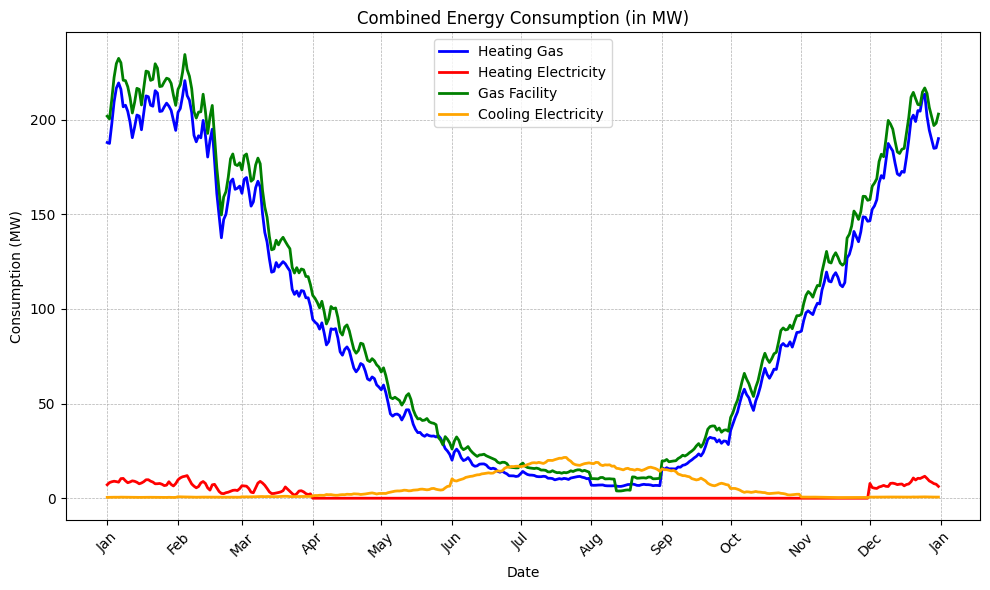

In [13]:
def plot_combined_variables_mw(df):
    # Variables to plot
    variables_to_plot = ['Heating Gas', 'Heating Electricity', 'Gas Facility', 'Cooling Electricity']
    colors = ['blue', 'red', 'green', 'orange']
    
    plt.figure(figsize=(10, 6))
    
    # Plot each variable
    for i, variable in enumerate(variables_to_plot):
        plt.plot(df['Date'], df[variable], linestyle='-', linewidth=2, color=colors[i], label=variable)
    
    plt.title('Combined Energy Consumption (in MW)')
    plt.xlabel('Date')
    plt.ylabel('Consumption (MW)')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Set major locator to month
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Call the function to plot with units converted to MW
plot_combined_variables_mw(agg_pd_date)

The graph displaying combined energy consumption provides a visual representation of seasonal energy usage patterns. It reveals clear trends in energy consumption, specifically regarding Heating Gas, Heating Electricity, Gas Facility, and Cooling Electricity throughout the year.

### Seasonal Analysis

- Winter Season: The data shows a significant increase in both Heating Gas and Heating Electricity during the winter months, peaking in December and January. This aligns with common expectations, as colder temperatures necessitate heating in residential and commercial buildings. The increased demand for heating energy during these months is consistent with the need for comfort and safety in colder climates, where temperatures can drop significantly.

- Summer Season: Conversely, during the summer months, there is a noticeable decline in Heating Gas and Heating Electricity consumption, reflecting the transition from heating needs to cooling needs. As temperatures rise, the demand for Cooling Electricity surges, especially from June through August. This is indicative of the increased reliance on air conditioning systems to maintain comfortable indoor environments, which is particularly critical in hotter regions.

- Interplay Between Heating and Cooling: The graph clearly illustrates the inverse relationship between heating and cooling energy consumption. For instance, while Heating Electricity and Heating Gas drop significantly in summer, Cooling Electricity rises correspondingly. This seasonal pattern highlights how energy consumption is intricately linked to climate and seasonal changes.

- Overall Energy Trends: Additionally, the Gas Facility's consumption appears to fluctuate throughout the year, although its trends are less pronounced than those of Heating and Cooling energies. This suggests that while gas facilities contribute to heating, their demand may be influenced by other factors, such as energy production requirements or market demands.

## Conclusion

In summary, this analysis of the graph underscores the relationship between seasonal changes and energy consumption patterns. Understanding these trends is important for energy planning and management, as they can inform strategies to enhance energy efficiency and sustainability. For example, energy providers can anticipate higher demand during peak heating and cooling seasons, allowing for better resource allocation and infrastructure planning. Overall, the graph serves as a tool for comprehending the dynamics of energy usage in response to seasonal variations.

In [15]:
!jupyter nbconvert --to webpdf --allow-chromium-download Load_analysis.ipynb

[NbConvertApp] Converting notebook Load_analysis.ipynb to webpdf
[NbConvertApp] Building PDF
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 263891 bytes to Load_analysis.pdf
